In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [2]:
!kaggle competitions download -c severstal-steel-defect-detection

 99% 1.56G/1.57G [00:20<00:00, 38.6MB/s]
100% 1.57G/1.57G [00:20<00:00, 83.5MB/s]


In [3]:
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/99f75320d.jpg  
  inflating: train_images/99f9d2375.jpg  
  inflating: train_images/99fd3c6f5.jpg  
  inflating: train_images/9a016fe15.jpg  
  inflating: train_images/9a064450d.jpg  
  inflating: train_images/9a08c2783.jpg  
  inflating: train_images/9a18e4457.jpg  
  inflating: train_images/9a1f7c238.jpg  
  inflating: train_images/9a2523ce9.jpg  
  inflating: train_images/9a3e774ff.jpg  
  inflating: train_images/9a5e9e77c.jpg  
  inflating: train_images/9a5f7a855.jpg  
  inflating: train_images/9a62177bb.jpg  
  inflating: train_images/9a67575cf.jpg  
  inflating: train_images/9a6ac5406.jpg  
  inflating: train_images/9a70057c0.jpg  
  inflating: train_images/9a72fd89e.jpg  
  inflating: train_images/9a75974ba.jpg  
  inflating: train_images/9a762b892.jpg  
  inflating: train_images/9a7b2f3af.jpg  
  inflating: train_images/9a7b427b4.jpg  
  inflating: train_images/9a81a8056.jpg  
  inflating: train_images

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn import preprocessing
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten

In [5]:
# Load CSV file for labels
data = pd.read_csv("/content/train.csv")

In [6]:
data.shape

(7095, 3)

In [7]:
data["ClassId"].value_counts()


ClassId
3    5150
1     897
4     801
2     247
Name: count, dtype: int64

In [8]:
l1=[]
l2=[]
for img,ClassId,EncodedPixels in tqdm(data.values):
    image=cv2.imread("/content/train_images/{}".format(img),cv2.IMREAD_COLOR)
    image=cv2.resize(image,(120,120))
    l1.append(image)
    l2.append(ClassId)


100%|██████████| 7095/7095 [00:51<00:00, 138.75it/s]


In [9]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = to_categorical(y)


In [10]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True)
print("x_train shape:",X_train.shape)
print("x_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)



x_train shape: (5676, 120, 120, 3)
x_test shape: (1419, 120, 120, 3)
y_train shape: (5676, 4)
y_test shape: (1419, 4)


In [11]:
from keras.applications import vgg16

In [12]:
img_rows, img_cols = 120, 120

In [13]:
vgg = vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (img_rows, img_cols, 3))



58889256/58889256 [==============================] - 0s 0us/step


In [14]:
# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in vgg.layers:
    layer.trainable = False


In [15]:
# Let's print our layers
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)



0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [16]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model


In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model


num_classes = 4

FC_Head = lw(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = FC_Head)

print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0     

In [18]:
from tensorflow.keras.models import Model
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])


In [19]:
from keras.callbacks import EarlyStopping

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [21]:
history = model.fit(X_train, y_train,
                    epochs=15,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    initial_epoch=0,
                    callbacks=[early_stopping])


Epoch 1/15
178/178 [==============================] - 24s 87ms/step - loss: 0.7019 - accuracy: 0.7352 - val_loss: 0.5804 - val_accuracy: 0.7576
Epoch 2/15
178/178 [==============================] - 11s 59ms/step - loss: 0.5574 - accuracy: 0.7726 - val_loss: 0.6016 - val_accuracy: 0.7364
Epoch 3/15
178/178 [==============================] - 10s 56ms/step - loss: 0.5153 - accuracy: 0.7856 - val_loss: 0.5794 - val_accuracy: 0.7456
Epoch 4/15
178/178 [==============================] - 10s 58ms/step - loss: 0.4824 - accuracy: 0.7963 - val_loss: 0.5462 - val_accuracy: 0.7766
Epoch 5/15
178/178 [==============================] - 10s 59ms/step - loss: 0.4805 - accuracy: 0.7914 - val_loss: 0.4848 - val_accuracy: 0.7956
Epoch 6/15
178/178 [==============================] - 11s 61ms/step - loss: 0.4776 - accuracy: 0.7900 - val_loss: 0.5215 - val_accuracy: 0.7893
Epoch 7/15
178/178 [==============================] - 10s 57ms/step - loss: 0.4570 - accuracy: 0.8062 - val_loss: 0.4633 - val_accuracy:

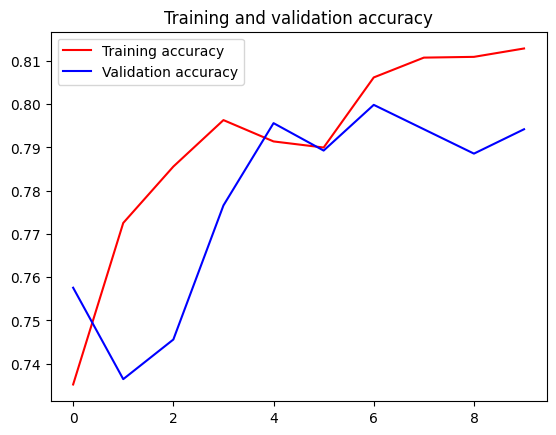

<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [23]:
y_prediction = model.predict(X_test)
y_prediction = np.argmax(y_prediction, axis=1)
y_test = np.argmax(y_test, axis=1)

45/45 [==============================] - 2s 42ms/step


In [24]:
from sklearn.metrics import classification_report

classification_report_ = classification_report(y_test, y_prediction)
print("Classification Report:")
print(classification_report_)

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.43      0.53       179
           1       0.81      0.42      0.55        50
           2       0.82      0.94      0.88      1030
           3       0.67      0.41      0.51       160

    accuracy                           0.80      1419
   macro avg       0.75      0.55      0.62      1419
weighted avg       0.79      0.80      0.78      1419



In [27]:
from sklearn.metrics import confusion_matrix,accuracy_score, f1_score, precision_score, recall_score

confusion_mtx = confusion_matrix(y_test, y_prediction)
print("Confusion Matrix:")
print(confusion_mtx)


Confusion Matrix:
[[ 77   5  95   2]
 [  4  21  25   0]
 [ 28   0 971  31]
 [  1   0  93  66]]


In [28]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_prediction)
print("Accuracy:", accuracy)


Accuracy: 0.7998590556730092


In [29]:
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_prediction, average='weighted', zero_division=1)
recall = recall_score(y_test, y_prediction, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_prediction, average='weighted', zero_division=1)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.7872133008760916
Recall: 0.7998590556730092
F1 Score: 0.780845570684589


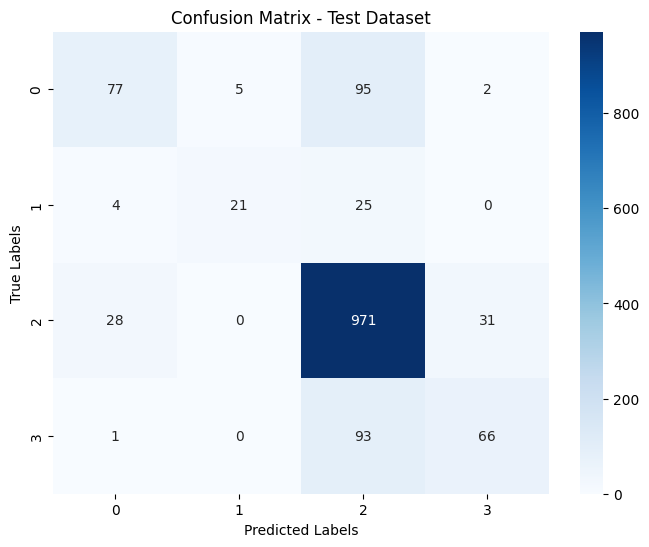

In [30]:
# Save the evaluation results or visualization if needed
# For example, save the confusion matrix plot

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Test Dataset")
plt.show()

In [32]:
# Save the final trained model
model.save('final_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
